In [1]:
CONSTRAINT_TOOLS = '/scratch/ucgd/lustre-work/quinlan/u6018199/constraint-tools'
CONSTRAINT_TOOLS_DATA = '/scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools'

import sys
sys.path.append(f'{CONSTRAINT_TOOLS}/utilities')

LOWER_DELETION_SIZE_LIMIT = 4000
UPPER_DELETION_SIZE_LIMIT = 10000
DELETION_ALLELE_FREQ_THRESHOLD = 0.00001

# Filter out false deletions: 
SUSPICIOUS_DELETION_SIZE_THRESHOLD = 1000000

DELETION_CLASS = 'observed' # TOPMED 

DELETION_TYPE = 'long' 

# create windows by subtracting 0.5*WINDOW_SIZE from enhancer_center and adding 0.5*WINDOW_SIZE to enhancer_center 
WINDOW_SIZE = 1000000

ENHANCERS_CLASS = 'labeled' # 'labeled' or 'genehancer'

CONSTRAINED = True
SINGLETON = None

## Get deletion coordinates relative to centers of enhancers 

In [2]:
from shell import shell
import pandas as pd

def f(): 
  # TODO: replace "XXX" with something more informative 
  windows_with_deletions = f'{CONSTRAINT_TOOLS_DATA}/windows-XXX-intersect-{DELETION_TYPE}-{DELETION_CLASS}-deletions.bed'

  intersect_script = f'{CONSTRAINT_TOOLS}/experiments/germline-model/chen-et-al-2022/intersect-windows-XXX-with-deletions.sh'

  cmd = (
    f'bash '
    f'{intersect_script} '
    f'{DELETION_CLASS} {windows_with_deletions} '
    f'{DELETION_TYPE} '
    f'{LOWER_DELETION_SIZE_LIMIT} {UPPER_DELETION_SIZE_LIMIT} {DELETION_ALLELE_FREQ_THRESHOLD} '
    f'{SUSPICIOUS_DELETION_SIZE_THRESHOLD} '
    f'{WINDOW_SIZE} '
    f'{ENHANCERS_CLASS}'
  )
  print(shell(cmd))

  df = pd.read_csv(
    windows_with_deletions, 
    sep='\t',
  )

  return df 

DF = f() 
DF


Wrote windows with deletion overlaps to: /scratch/ucgd/lustre-work/quinlan/data-shared/constraint-tools/windows-XXX-intersect-long-observed-deletions.bed



,window_chrom,window_start,window_end,enhancer_chrom,enhancer_start,enhancer_end,gene,enhancer_Gnocchi,Haploinsufficient,MGI essential,...,SAS_Male_Het,SAS_Male_HomAlt,SAS_Male_HemiAlt,SAS_Male_HemiAF,SAS_Female_AF,SAS_Female_HomRef,SAS_Female_Het,SAS_Female_HomAlt,PopMax_AF,InPop
0,chr1,2045261,3045261,chr1,2545161,2545361,PANK4,2.775673,False,False,...,0,0,0,0.0,0.0,1378,0,0,0.000012,1
1,chr1,2045261,3045261,chr1,2545161,2545361,PANK4,2.775673,False,False,...,0,0,0,0.0,0.0,1378,0,0,0.000107,1
2,chr1,2045261,3045261,chr1,2545161,2545361,PANK4,2.775673,False,False,...,0,0,0,0.0,0.0,1378,0,0,0.000006,1
3,chr1,2045261,3045261,chr1,2545161,2545361,PANK4,2.775673,False,False,...,0,0,0,0.0,0.0,1364,0,0,0.000283,2
4,chr1,2045261,3045261,chr1,2545161,2545361,PANK4,2.775673,False,False,...,0,0,0,0.0,0.0,1372,0,0,0.000073,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73252,chr9,122308421,123308421,chr9,122807921,122808921,OR5C1,3.383762,False,False,...,0,0,0,0.0,0.0,1376,0,0,0.000006,1
73253,chr9,122308421,123308421,chr9,122807921,122808921,OR5C1,3.383762,False,False,...,0,0,0,0.0,0.0,1378,0,0,0.000019,1
73254,chr9,122308421,123308421,chr9,122807921,122808921,OR5C1,3.383762,False,False,...,0,0,0,0.0,0.0,1378,0,0,0.000006,1
73255,chr9,122308421,123308421,chr9,122807921,122808921,OR5C1,3.383762,False,False,...,0,0,0,0.0,0.0,1376,0,0,0.000012,1


In [3]:
# def g_genehancer(df, singleton): 
#   df = df[
#     (df['window_chrom'] != 'chrX') &
#     (df['window_chrom'] != 'chrY')
#   ]
#   df = df[df['element'] == 'Enhancer']  
#   df = df[df['elite'] == 1]

#   df = df[['window_chrom', 'window_start', 'window_end', 'START', 'END', 'Het', 'SVLEN']]
#   df = df.rename(columns={
#     'START': 'deletion_start',
#     'END': 'deletion_end',
#     'Het': 'number_of_het_samples',
#     'SVLEN': 'deletion_size',
#   })

#   df['singleton'] = df['number_of_het_samples'] == 1
#   df = df[df['singleton'] == singleton]

#   df['window_center'] = (df['window_start'] + df['window_end']) / 2
#   df['deletion_center'] = (df['deletion_start'] + df['deletion_end']) / 2

#   df['deletion_start_new'] = df['deletion_start'] - df['window_center']
#   df['deletion_end_new'] = df['deletion_end'] - df['window_center']
#   df['deletion_center_new'] = df['deletion_center'] - df['window_center']

#   df['deletion_start_new'] = df['deletion_start_new'].clip(-0.5*WINDOW_SIZE, 0.5*WINDOW_SIZE)
#   df['deletion_end_new'] = df['deletion_end_new'].clip(-0.5*WINDOW_SIZE, 0.5*WINDOW_SIZE)
#   df['deletion_center_new'] = df['deletion_center_new'].clip(-0.5*WINDOW_SIZE, 0.5*WINDOW_SIZE)

#   return df[['deletion_start_new', 'deletion_end_new', 'deletion_center_new']].to_records(index=False).tolist()

In [4]:
pd.set_option('display.max_rows', 50)

def g_labeled(df): 
  df = df[[
    'window_chrom', 
    'window_start', 
    'window_end', 
    'deletion_count',
    'sum merged_deletion_overlap',
    'enhancer coordinates',
    'enhancer_length',
    'deletion count per bp',
    'fraction of bps that are deleted',
    'truly constrained',
    'START', 
    'END', 
    'Het', 
    'SVLEN'
  ]]

  df = df[df['truly constrained'] == CONSTRAINED]

  df = df[
    (df['window_chrom'] != 'chrX') &
    (df['window_chrom'] != 'chrY')
  ]

  df = df.rename(columns={
    'START': 'deletion_start',
    'END': 'deletion_end',
    'Het': 'number_of_het_samples',
    'SVLEN': 'deletion_size',
  })

  df['singleton'] = df['number_of_het_samples'] == 1
  if SINGLETON is not None:
    df = df[df['singleton'] == SINGLETON]

  df['window_center'] = (df['window_start'] + df['window_end']) / 2
  df['deletion_center'] = (df['deletion_start'] + df['deletion_end']) / 2

  df['deletion_start_new'] = df['deletion_start'] - df['window_center']
  df['deletion_end_new'] = df['deletion_end'] - df['window_center']
  df['deletion_center_new'] = df['deletion_center'] - df['window_center']

  df['deletion_start_new'] = df['deletion_start_new'].clip(-0.5*WINDOW_SIZE, 0.5*WINDOW_SIZE)
  df['deletion_end_new'] = df['deletion_end_new'].clip(-0.5*WINDOW_SIZE, 0.5*WINDOW_SIZE)
  df['deletion_center_new'] = df['deletion_center_new'].clip(-0.5*WINDOW_SIZE, 0.5*WINDOW_SIZE)

  return df

DF2 = g_labeled(DF)
DF2.iloc[:20]

,window_chrom,window_start,window_end,deletion_count,sum merged_deletion_overlap,enhancer coordinates,enhancer_length,deletion count per bp,fraction of bps that are deleted,truly constrained,deletion_start,deletion_end,number_of_het_samples,deletion_size,singleton,window_center,deletion_center,deletion_start_new,deletion_end_new,deletion_center_new
0,chr1,2045261,3045261,0,0,chr1:2545161-2545361,200,0.0,0.0,True,2359641,2374639,1,14998,True,2545261.0,2367140.0,-185620.0,-170622.0,-178121.0
1,chr1,2045261,3045261,0,0,chr1:2545161-2545361,200,0.0,0.0,True,2623472,2637639,1,14167,True,2545261.0,2630555.5,78211.0,92378.0,85294.5
2,chr1,2045261,3045261,0,0,chr1:2545161-2545361,200,0.0,0.0,True,2139310,2164623,1,25313,True,2545261.0,2151966.5,-405951.0,-380638.0,-393294.5
3,chr1,2045261,3045261,0,0,chr1:2545161-2545361,200,0.0,0.0,True,2263528,2285172,46,21644,False,2545261.0,2274350.0,-281733.0,-260089.0,-270911.0
4,chr1,2045261,3045261,0,0,chr1:2545161-2545361,200,0.0,0.0,True,2268800,2283700,1,14900,True,2545261.0,2276250.0,-276461.0,-261561.0,-269011.0
5,chr1,2045261,3045261,0,0,chr1:2545161-2545361,200,0.0,0.0,True,2311495,2328799,1,17304,True,2545261.0,2320147.0,-233766.0,-216462.0,-225114.0
6,chr1,2045261,3045261,0,0,chr1:2545161-2545361,200,0.0,0.0,True,2340700,2354500,1,13800,True,2545261.0,2347600.0,-204561.0,-190761.0,-197661.0
7,chr1,2045261,3045261,0,0,chr1:2545161-2545361,200,0.0,0.0,True,2370968,2388840,15,17872,False,2545261.0,2379904.0,-174293.0,-156421.0,-165357.0
8,chr1,2045261,3045261,0,0,chr1:2545161-2545361,200,0.0,0.0,True,2412433,2445051,1,32618,True,2545261.0,2428742.0,-132828.0,-100210.0,-116519.0
9,chr1,2045261,3045261,0,0,chr1:2545161-2545361,200,0.0,0.0,True,2417506,2486864,1,69358,True,2545261.0,2452185.0,-127755.0,-58397.0,-93076.0


## Visualize pileup of deletions in the vicinity of enhancers
https://www.nxn.se/valent/visualizing-overlapping-intervals

In [5]:
# TODO 
# color deletions by singleton status 

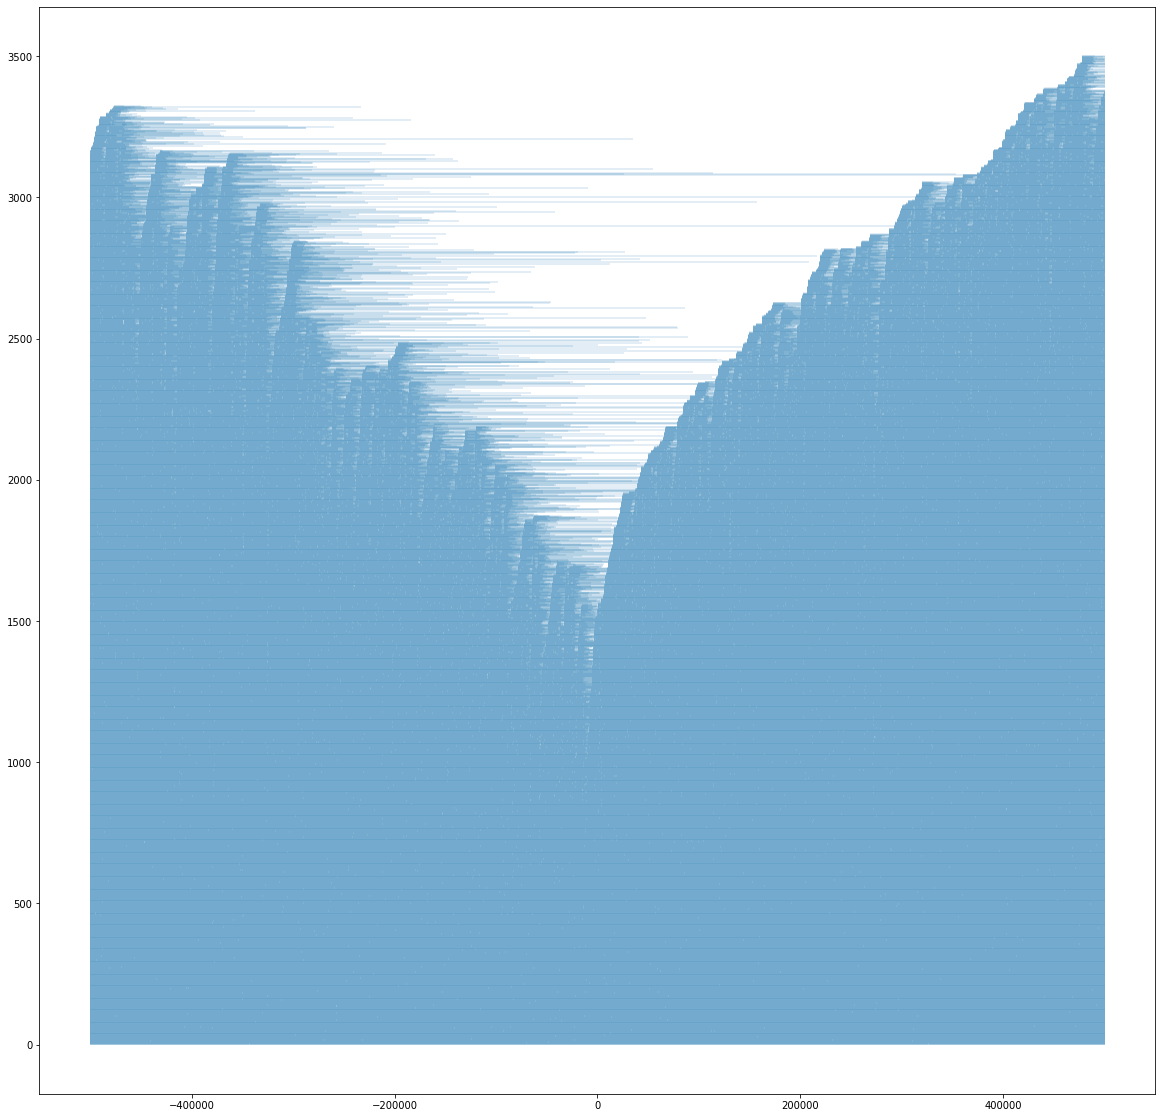

In [6]:
import matplotlib.pyplot as plt

# intervals = [(2, 6), (7, 10), (1, 3), (4, 6), (8, 10), (1, 2), (3, 7), (9, 10), (1, 2), (3, 5), (6, 7), (8, 10), (2, 5), (8, 10)]
intervals_with_centers = DF2[['deletion_start_new', 'deletion_end_new', 'deletion_center_new']].to_records(index=False).tolist()

intervals = [(left, right) for left, right, center in intervals_with_centers]

def intervals2layers(si):
    layers = [[si[0]]]
    for p in si[1:]:
        for lay in layers:
            if lay[-1][-1] < p[0]:
                lay.append(p)
                break
        else:
            layers.append([p])

    return layers

si = sorted(intervals, key=lambda p: p[0])
layers = intervals2layers(si)

plt.figure(figsize=(20, 20))

for i, lay in enumerate(layers):
    x1, x2 = zip(*lay)
    plt.hlines([i + 1] * len(x1), x1, x2, lw=0.25) # type: ignore


# plt.xlim(0, 11)
# plt.ylim(0, 6)

In [7]:
# import random 

# intervals = []
# for i in range(1024):
#     x1 = random.normalvariate(0.5, 0.25)
#     x2 = x1 + random.random() / 16
#     intervals.append((x1, x2))

# si = sorted(intervals, key=lambda p: p[0])
# layers = intervals2layers(si)

# for i, lay in enumerate(layers):
#     x1, x2 = zip(*lay)
#     plt.hlines([i + 1] * len(x1), x1, x2)


In [8]:
# # intervals = [(2, 6), (7, 10), (1, 3), (4, 6), (8, 10), (1, 2), (3, 7), (9, 10), (1, 2), (3, 5), (6, 7), (8, 10), (2, 5), (8, 10)]
# intervals = g(DF, singleton=False)[:3000]

# plt.figure(figsize=(20, 20))

# for i, interval in enumerate(intervals):
#     x1, x2 = interval
#     plt.hlines(i, x1, x2, lw=0.25)


# # plt.xlim(0, 11)
# # plt.ylim(0, 6)

(array([8026., 6334., 5964., 5594., 4880., 5195., 5667., 6068., 6400.,
        8435.]),
 array([-500000., -400000., -300000., -200000., -100000.,       0.,
         100000.,  200000.,  300000.,  400000.,  500000.]),
 <BarContainer object of 10 artists>)

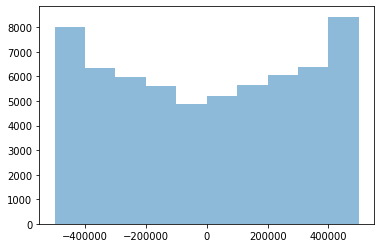

In [9]:
x1, x2, centers = zip(*intervals_with_centers)

plt.hist(centers, alpha=0.5)

## [TODO] Repeat analysis, but replacing enhancers with exons 

## Compute per-bp coverage of deletions in the vicinity of enhancers

https://www.geeksforgeeks.org/maximum-number-of-overlapping-intervals/ 

In [10]:
# TODO 
# Generalize the code below to include a per-bp coverage variable that is updated as the intervals are traversed 

In [11]:
# # Python3 program that print maximum
# # number of overlap
# # among given ranges

# # Function that print maximum
# # overlap among ranges
# def overlap(v):

# 	# variable to store the maximum
# 	# count
# 	ans = 0
# 	count = 0
# 	data = []

# 	# storing the x and y
# 	# coordinates in data vector
# 	for i in range(len(v)):

# 		# pushing the x coordinate
# 		data.append([v[i][0], 'x'])

# 		# pushing the y coordinate
# 		data.append([v[i][1], 'y'])

# 	# sorting of ranges
# 	data = sorted(data)

# 	# Traverse the data vector to
# 	# count number of overlaps
# 	for i in range(len(data)):

# 		# if x occur it means a new range
# 		# is added so we increase count
# 		if (data[i][1] == 'x'):
# 			count += 1

# 		# if y occur it means a range
# 		# is ended so we decrease count
# 		if (data[i][1] == 'y'):
# 			count -= 1

# 		# updating the value of ans
# 		# after every traversal
# 		ans = max(ans, count)

# 	# printing the maximum value
# 	print(ans)

# # Driver code
# v = [ [ 1, 2 ], [ 2, 4 ], [ 3, 6 ] ]
# overlap(v)

# # This code is contributed by mohit kumar 29
